# 第八章　コージェネレーション設備 / Chapter 8 Cogeneration system

In [1]:
import numpy as np

# 試算例

### 初期条件

In [2]:
def get_default_house():
    
    house = {
        # 基本情報
        'type': '一般住宅',
        "evaluation_method": "住戸全体を対象に評価する",
        'tatekata': '戸建住宅',
        'A_A': 120.08,
        'A_MR': 29.81,
        'A_OR': 51.34,
        'region': 6,
        'sol_region': None,
        'reference': {'result_type': '建築物エネルギー消費性能基準（H28 年 4 月以降）', 'reference_year': 'H28'},

        # 外皮
        'ENV': {"A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8,
                'method': '当該住宅の外皮面積の合計を用いて評価する', 'tatekata': '戸建住宅'},
        "NV_MR": 0, "NV_OR": 0,

        'r_A_ufvnt': None,
        'HEX': None,
        'underfloor_insulation': None,
        'TS': None,

        # 暖房
        'mode_H': '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合',
        'H_MR': {'type': '温水暖房用パネルラジエーター'},
        'H_OR': {'type': 'ルームエアコンディショナー', 'e_class': 'は', 'dualcompressor': False},
        'H_A': None,
        'H_HS': {'type': 'コージェネレーションを使用する', 'pipe_insulation': False, 'underfloor_pipe_insulation': False},

        # 冷房
        'mode_C': '居室のみを冷房する方式',
        'C_A': None,
        'C_MR': {"type": "ルームエアコンディショナー", 'e_class': 'は', 'dualcompressor': False},
        'C_OR': {'type': 'ルームエアコンディショナー', 'e_class': 'は', 'dualcompressor': False},

        # 換気
        'V': {'type': 'ダクト式第二種換気設備又はダクト式第三種換気設備',
              'input': '比消費電力', 'f_SFP': 0.40, 'N': 0.5},

        # 熱交換
        'HEX': None,

        # 給湯
        'HW': {'hw_type': 'コージェネレーションを使用する',
               'bath_function': 'ふろ給湯機(追焚あり)', 'has_bath': True, 'pipe_diameter': '上記以外',
               'kitchen_watersaving_A': False, 'kitchen_watersaving_C': False,  'shower_watersaving_A': False,
               'shower_watersaving_B': False, 'washbowl_watersaving_C': False, 'bath_insulation': False},
        
        # 照明
        'L': {'MR_installed': '設置しない', 'MR_power': None, 'MR_multi': None, 'MR_dimming': None,
              'has_OR': True, 'OR_installed': '設置しない', 'OR_power': None, 'OR_dimming': None,
              'has_NO': True, 'NO_installed': '設置しない', 'NO_power': None, 'NO_sensor': None,
              },

        # PV
        'PV': None,

        # 太陽熱
        'SHC': None,

        # コージェネ
        'CG': {'CG_category': 'SOFC1'}

    }

    return house



### 計算

In [3]:
def calc_results(house):
    
    if __name__ == '__main__':
        
        from pyhees.section2_1_b import get_f_prim
        from pyhees.section2_2 import calc_E_H, calc_E_W, get_E_E_CG_h, calc_E_E, get_E_E_CG_sell_d_t, calc_E_CG_sell, get_E_E_CG_self, calc_E_G_CG_sell
        from pyhees.section3_1 import get_Q
        from pyhees.section3_2 import calc_insulation_performance
        from pyhees.section4_1 import calc_heating_load, calc_cooling_load, calc_heating_mode, get_virtual_heating_devices, get_virtual_heatsource
        from pyhees.section7_1_b import get_virtual_hotwater

        house['ENV']['A_A'] = house['A_A']
        solrad = None
        heating_flag_d = None

        # ---- 外皮の計算 ----
        r_env, Q_dash, mu_H, mu_C = calc_insulation_performance(**house['ENV'])
        # 外皮の断熱性能の計算
        if house['ENV'] is not None:
            # 熱損失係数
            Q = get_Q(Q_dash)
        else:
            Q = None
            mu_H, mu_C = None, None


        # ---- 暖房設備 ----

        # 1 時間当たりの暖房設備の設計一次エネルギー消費量

        # 実質的な暖房機器の仕様を取得
        spec_MR, spec_OR = get_virtual_heating_devices(house['region'], house['H_MR'], house['H_OR'])

        # 暖房方式及び運転方法の区分
        mode_MR, mode_OR = calc_heating_mode(region=house['region'], H_MR=spec_MR, H_OR=spec_OR)

        # ---- 暖房負荷 ----
        L_T_H_d_t_i, L_dash_H_R_d_t_i = calc_heating_load(
            house['region'], house['sol_region'],
            house['A_A'], house['A_MR'], house['A_OR'],
            Q, mu_H, mu_C, house['NV_MR'], house['NV_OR'], house['TS'], house['r_A_ufvnt'], house['HEX'],
            house['underfloor_insulation'], house['mode_H'], house['mode_C'],
            spec_MR, spec_OR, mode_MR, mode_OR, house['SHC'])
        

        # ---- 冷房負荷 ----
        # 冷房負荷の取得
        L_CS_d_t, L_CL_d_t = \
            calc_cooling_load(house['region'], house['A_A'], house['A_MR'], house['A_OR'], Q, mu_H, mu_C,
                            house['NV_MR'], house['NV_OR'], house['r_A_ufvnt'], house['underfloor_insulation'],
                            house['mode_C'], house['mode_H'], mode_MR, mode_OR, house['TS'], house['HEX'])

        # ---- 暖房設備 ----
        # 1 時間当たりの暖房設備の設計一次エネルギー消費量

        # 実質的な温水暖房機の仕様を取得
        spec_HS = get_virtual_heatsource(house['region'], house['H_HS'])

        E_H = calc_E_H(house['region'], house['sol_region'], house['A_A'], house['A_MR'], house['A_OR'], r_env, mu_H, mu_C, Q,
                       house['mode_H'], house['H_A'], spec_MR, spec_OR, spec_HS, mode_MR, mode_OR, house['HW'], house['CG'], house['SHC'],
                       heating_flag_d, L_T_H_d_t_i, L_CS_d_t, L_CL_d_t)


        # ---- 給湯/コージェネ設備 ----

        # その他または設置しない場合
        spec_HW = get_virtual_hotwater(house['region'], house['HW'])

        # 1 年当たりの給湯設備（コージェネレーション設備を含む）の設計一次エネルギー消費量
        E_W, E_E_CG_gen_d_t, _, E_E_TU_aux_d_t, E_E_CG_h_d_t, E_G_CG_ded, e_BB_ave, Q_CG_h \
                = calc_E_W(house['A_A'], house['region'], house['sol_region'], spec_HW, house['SHC'], house['CG'], house['H_A'],
                           house['H_MR'], house['H_OR'], house['H_HS'], house['C_A'], house['C_MR'], house['C_OR'], house['V'],
                           house['L'], house['A_MR'], house['A_OR'], house['ENV']['A_env'], Q, mu_H, mu_C, house['NV_MR'],
                           house['NV_OR'], house['TS'], house['r_A_ufvnt'], house['HEX'], house['underfloor_insulation'],
                           house['mode_H'], house['mode_C'])


        # 1 年当たりの設計消費電力量（kWh/年）
        _, _, _, E_E_CG_gen_d_t, E_E_CG_h_d_t, _, E_E_TU_aux_d_t = \
                    calc_E_E(house['region'], house['sol_region'], house['A_A'], house['A_MR'], house['A_OR'], r_env, spec_HW, Q, 
                             house['TS'], mu_H, mu_C, house['r_A_ufvnt'], house['underfloor_insulation'], house['NV_MR'], house['NV_OR'],
                            house['mode_H'], house['mode_C'], house['V'], house['L'], house['H_A'], house['H_MR'], house['H_OR'], house['H_HS'],
                            house['CG'], house['SHC'], L_T_H_d_t_i, house['C_A'], house['C_MR'], house['C_OR'], L_T_H_d_t_i,
                            L_CS_d_t, L_CL_d_t, house['HEX'], house['PV'], solrad)


        # ---- エネルギー利用効率化の評価 ----
        if house['CG'] is not None:
            has_CG_reverse = house['CG']["reverse"] if 'reverse' in house['CG'] else False
        else:
            has_CG_reverse = False

        # エネルギー利用効率化設備による設計一次エネルギー消費量の削減量
        E_E_CG_h = get_E_E_CG_h(E_E_CG_h_d_t) # 1時間当たりのコージェネレーション設備による発電量のうちの自家消費分 (kWh/h) 

        # 1時間当たりのコージェネレーション設備による売電量(二次エネルギー) (kWh/h)
        E_E_CG_sell_d_t = get_E_E_CG_sell_d_t(E_E_CG_gen_d_t, E_E_CG_h_d_t, has_CG_reverse)

        # 1年当たりのコージェネレーション設備による売電量（一次エネルギー換算値）(MJ/yr)
        E_CG_sell = calc_E_CG_sell(E_E_CG_sell_d_t)

        # 1年当たりのコージェネレーション設備による発電量のうちの自己消費分 (kWH/yr)
        E_E_CG_self = get_E_E_CG_self(E_E_TU_aux_d_t)

        # 1年当たりのコージェネレーション設備による売電量に係るガス消費量の控除量 (MJ/yr)
        E_G_CG_sell = calc_E_G_CG_sell(E_CG_sell, E_E_CG_self, E_E_CG_h, E_G_CG_ded, e_BB_ave, Q_CG_h, house['CG'] != None)


        # 電気の一次エネルギー換算係数
        f_prim = get_f_prim()

        print(f'暖房消費量E_H:{np.sum(E_H)}MJ/a')
        print(f'給湯消費量(E_W):{np.sum(E_W)}MJ/a')
        print(f'CGSの発電量:{np.sum(E_E_CG_gen_d_t)*f_prim/1000}MJ/a')
        print(f'CGSの自家消費量:{np.sum(E_E_CG_h_d_t)*f_prim/1000}MJ/a')
        print(f'CGSの売電量:{np.sum(E_E_CG_sell_d_t)*f_prim/1000}MJ/a')
        print(f'コージェネレーション設備の売電量に係るガス消費量の控除量:{E_G_CG_sell}MJ/a')

        return E_H, E_W, E_E_CG_gen_d_t, E_E_CG_h_d_t, E_E_CG_sell_d_t, E_G_CG_sell
    
    

In [4]:
def get_each_graph(E_E_CG_gen_d_t, E_E_CG_h_d_t):

    import matplotlib.pyplot as plt

    E_E_CG_gen_d = np.sum(E_E_CG_gen_d_t.reshape(365,24), axis = 1)
    E_E_CG_h_d = np.sum(E_E_CG_h_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,15))

    grh_day = fig.add_subplot(411)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(E_E_CG_gen_d, label = "E_E_CG_gen")    
    grh_day.plot(E_E_CG_h_d, label = "E_E_CG_self")
    grh_day.legend()

    grh_date = fig.add_subplot(412)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(E_E_CG_gen_d_t.reshape(365,24)[151], label = "E_E_CG_gen:6/1")
    grh_date.plot(E_E_CG_h_d_t.reshape(365,24)[151], label = "E_E_CG_self:6/1")
    grh_date.legend()

    grh_date = fig.add_subplot(413)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(E_E_CG_gen_d_t.reshape(365,24)[212], label = "E_E_CG_gen:8/1")
    grh_date.plot(E_E_CG_h_d_t.reshape(365,24)[212], label = "E_E_CG_self:8/1")
    grh_date.legend()

    grh_date = fig.add_subplot(414)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(E_E_CG_gen_d_t.reshape(365,24)[334], label = "E_E_CG_gen:12/1")
    grh_date.plot(E_E_CG_h_d_t.reshape(365,24)[334], label = "E_E_CG_self:12/1")
    grh_date.legend()

    plt.show()


### 計算条件1

- 初期条件での計算

In [5]:
house = get_default_house()
E_H_1, E_W_1, E_E_CG_gen_d_t_1, E_E_CG_h_d_t_1, E_E_CG_sell_d_t_1, E_G_CG_sell_1 = calc_results(house)


暖房消費量E_H:3042.364958675187MJ/a
給湯消費量(E_W):66610.02598944267MJ/a
CGSの発電量:30901.359465565078MJ/a
CGSの自家消費量:30901.359465565078MJ/a
CGSの売電量:0.0MJ/a
コージェネレーション設備の売電量に係るガス消費量の控除量:0.0MJ/a


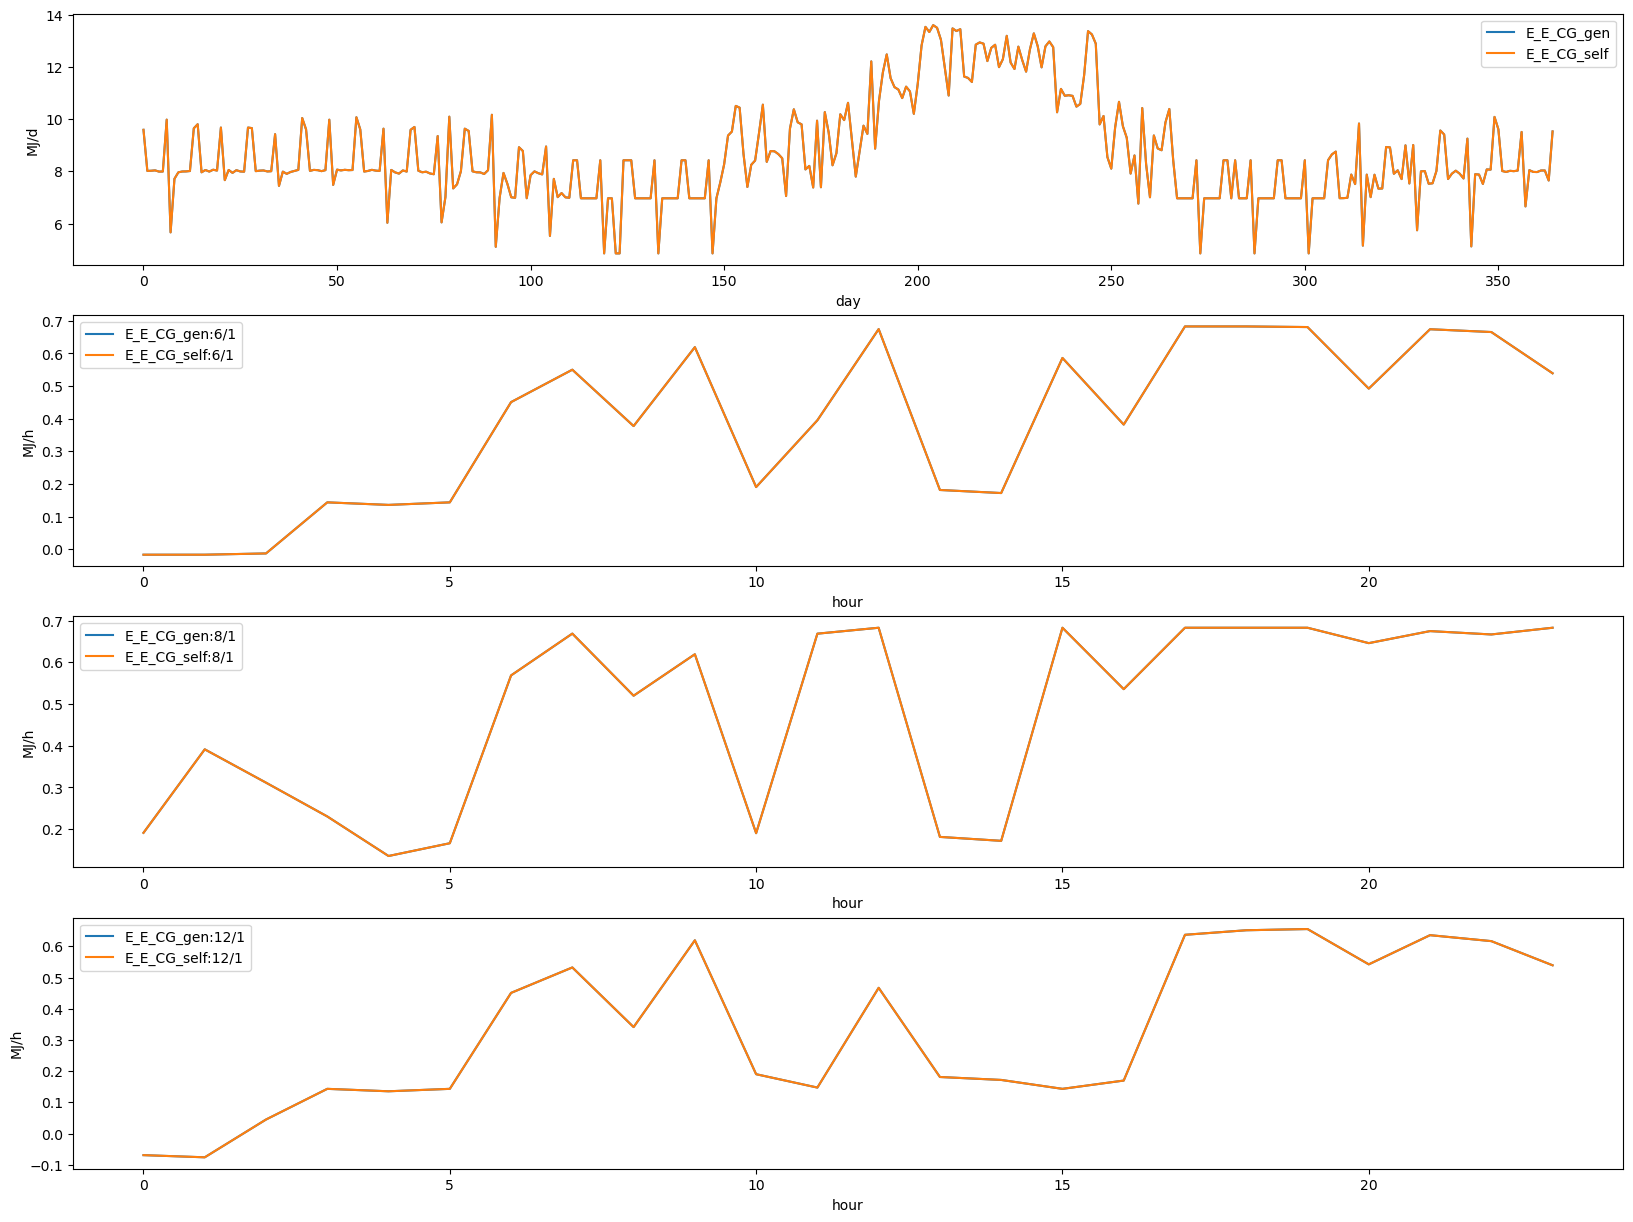

In [6]:
get_each_graph(E_E_CG_gen_d_t_1, E_E_CG_h_d_t_1)

### 計算条件2

- コージェネレーション機器の指定（品番を指定する）に変更(PEFC)  
    - ブランド事業者名 : パナソニック株式会社アプライアンス社  
    - 発電ユニット製造事業者名 : パナソニック株式会社アプライアンス社  
    - 発電ユニット番号（発電・貯湯一体型ユニット含む） : FC-70LR1PZ  
    - 貯湯ユニット製造事業者名 : 株式会社ノーリツ  
    - 貯湯ユニット品番（貯湯・補助熱源一体型ユニット含む） : FC-NULR1PZ  
    - 補助熱源機製造事業者名 : -  
    - 補助熱源機品番 : -  
    - 発売予定年月日 : 2021年04月01日


In [7]:
house = get_default_house()
house['CG'] = {'exhaust': True, 'exhaust_priority': '給湯優先', 'type_BB_HWH': 'G_EJ', 'r_DHW_gen_PU_d': 0.7842, 'r_HWH_gen_PU_d': 0.0966, 
                'PU_type': '熱主',  'param_E_E_gen_PU_Evt_d': {'a_PU': 0.0000, 'a_DHW': 0.0870, 'a_HWH': 0.0870, 'b': 22.6283, 'c': 0.9722},  
                'param_E_F_PU_HVt_d': {'a_DHW': 1, 'a_HWH': 1},  'param_r_H_gen_PU_HVt_d': {'a_DHW': 0.00000, 'a_HWH': 0.00000, 'b': 1.09776}, 
                'param_e_E_PU_d': {'a_PU': 0.000000, 'a_DHW': 0.000111, 'a_HWH': 0.000111, 'b': 0.3024, 'e_E_PU_d_max': 0.3269, 'e_E_PU_d_min': 0.2964}, 
                'param_e_H_PU_d': {'a_PU': 0.000000, 'a_DHW': -0.000182, 'a_HWH': 0.000000, 'b': 0.5088, 'e_H_PU_d_max': 0.5178, 'e_H_PU_d_min': 0.4892}, 
                'P_rtd_PU': 700, 'P_TU_aux_DHW': 5.2, 'P_TU_aux_HWH': 106.6, 'reverse': False}

E_H_2, E_W_2, E_E_CG_gen_d_t_2, E_E_CG_h_d_t_2, E_E_CG_sell_d_t_2, E_G_CG_sell_2 = calc_results(house)

暖房消費量E_H:3042.364958675187MJ/a
給湯消費量(E_W):56202.43934146989MJ/a
CGSの発電量:24621.39738294063MJ/a
CGSの自家消費量:24621.39738294063MJ/a
CGSの売電量:0.0MJ/a
コージェネレーション設備の売電量に係るガス消費量の控除量:0.0MJ/a


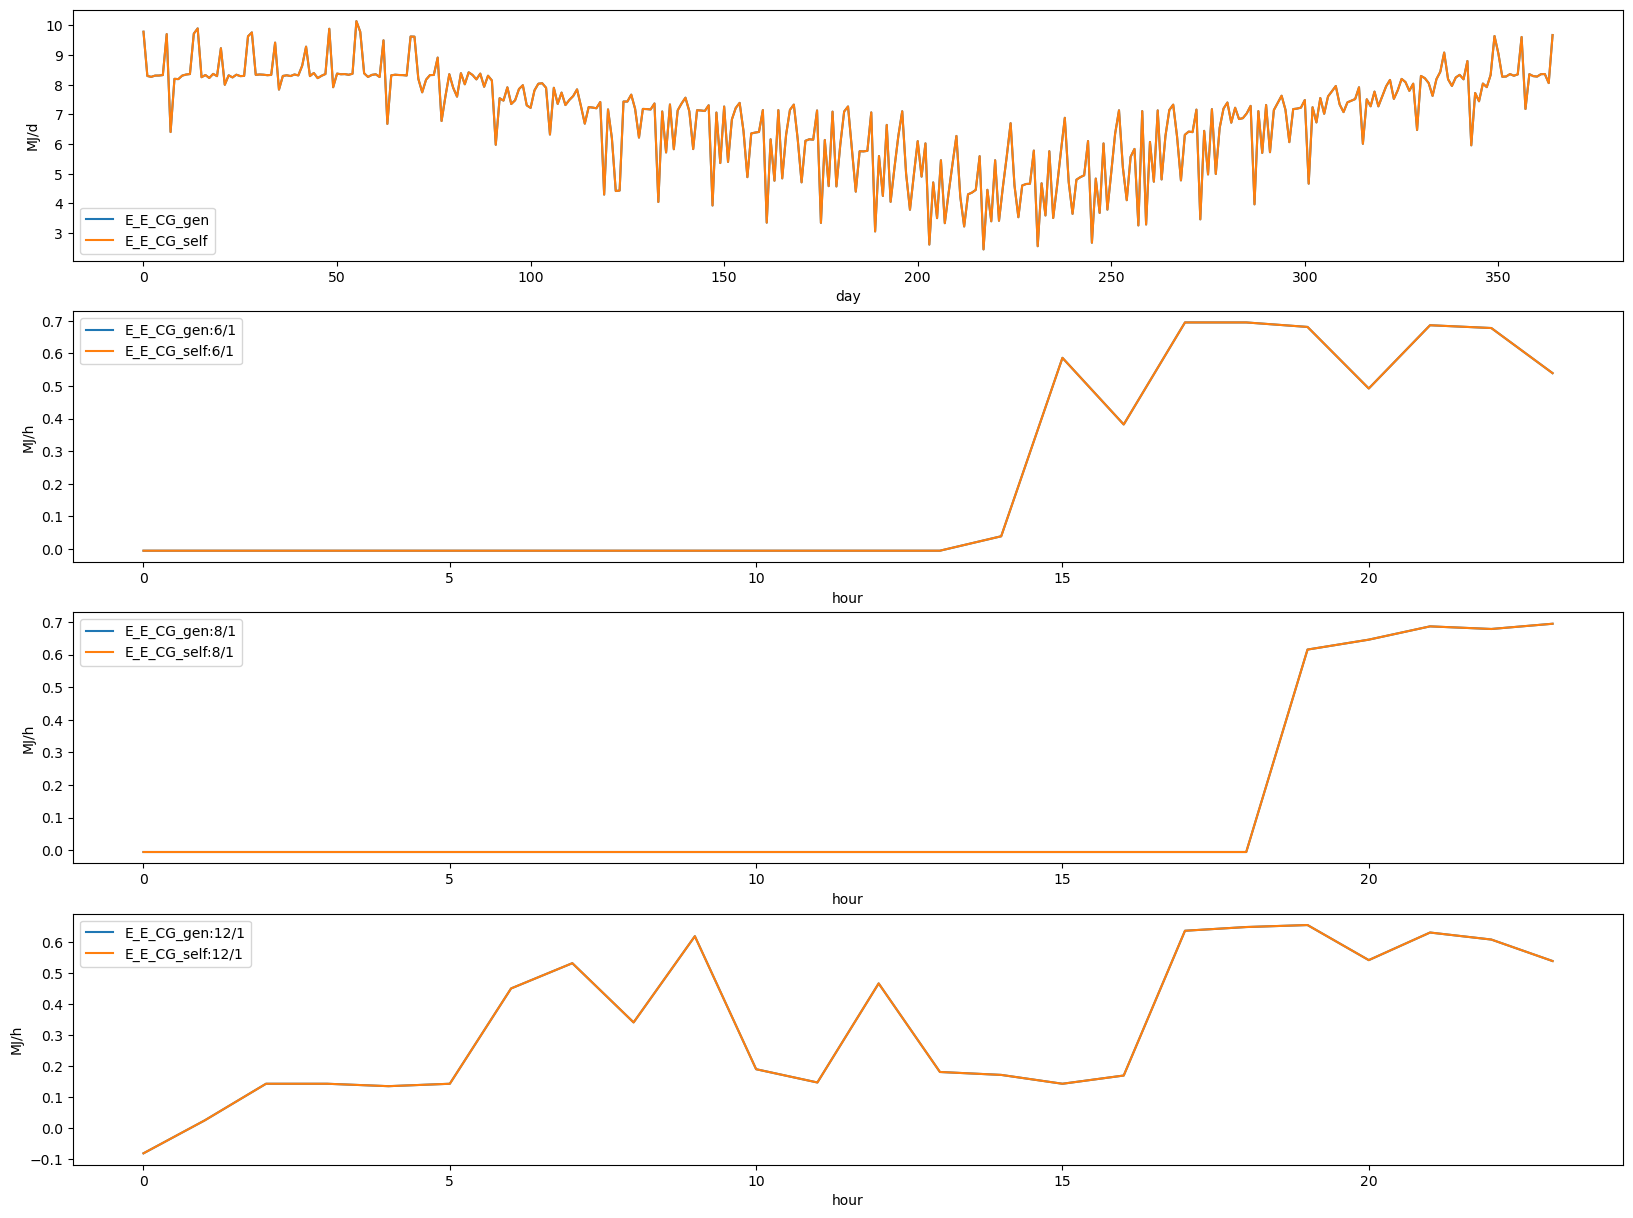

In [8]:
get_each_graph(E_E_CG_gen_d_t_2, E_E_CG_h_d_t_2)

### 計算条件3

- コージェネレーション機器の指定（品番を指定する）に変更(SOFC)  
    - ブランド事業者名 : アイシン精機株式会社
    - 発電ユニット製造事業者名 : アイシン精機株式会社
    - 発電ユニット番号（発電・貯湯一体型ユニット含む） : FCCS07C1NJ[baiden2]
    - 貯湯ユニット製造事業者名 : -
    - 貯湯ユニット品番（貯湯・補助熱源一体型ユニット含む） : -
    - 補助熱源機製造事業者名 : リンナイ株式会社
    - 補助熱源機品番 : RVD-E2405SAW2-1S(A)
    - 発売予定年月日 : 2020年04月01日


In [9]:
house = get_default_house()
house['CG'] = {'exhaust': False, 'exhaust_priority': None, 'type_BB_HWH': 'G_EJ', 'r_DHW_gen_PU_d': 0.3393, 'r_HWH_gen_PU_d': None, 
                'PU_type': '電主', 'param_E_E_gen_PU_Evt_d': {'a_PU': 1.0100, 'a_DHW': 0.0000, 'a_HWH': 0.0000, 'b': 0.0000, 'c': 1.0000},  
                'param_E_F_PU_HVt_d': None, 'param_r_H_gen_PU_HVt_d': None,  
                'param_e_E_PU_d': {'a_PU': 0.000000, 'a_DHW': 0.000000, 'a_HWH': 0.000000, 'b': 0.4683, 'e_E_PU_d_max': 0.4732, 'e_E_PU_d_min': 0.4625}, 
                'param_e_H_PU_d': {'a_PU': 0.000000, 'a_DHW': 0.000000, 'a_HWH': 0.000000, 'b': 0.3443, 'e_H_PU_d_max': 0.3536, 'e_H_PU_d_min': 0.3286}, 
                'P_rtd_PU': 700, 'P_TU_aux_DHW': 4.4, 'P_TU_aux_HWH': None, 'reverse': True}

E_H_3, E_W_3, E_E_CG_gen_d_t_3, E_E_CG_h_d_t_3, E_E_CG_sell_d_t_3, E_G_CG_sell_3 = calc_results(house)

暖房消費量E_H:3042.364958675187MJ/a
給湯消費量(E_W):79944.09028374376MJ/a
CGSの発電量:58194.37312667655MJ/a
CGSの自家消費量:33464.29404801449MJ/a
CGSの売電量:24730.07907866207MJ/a
コージェネレーション設備の売電量に係るガス消費量の控除量:18754.754589958728MJ/a


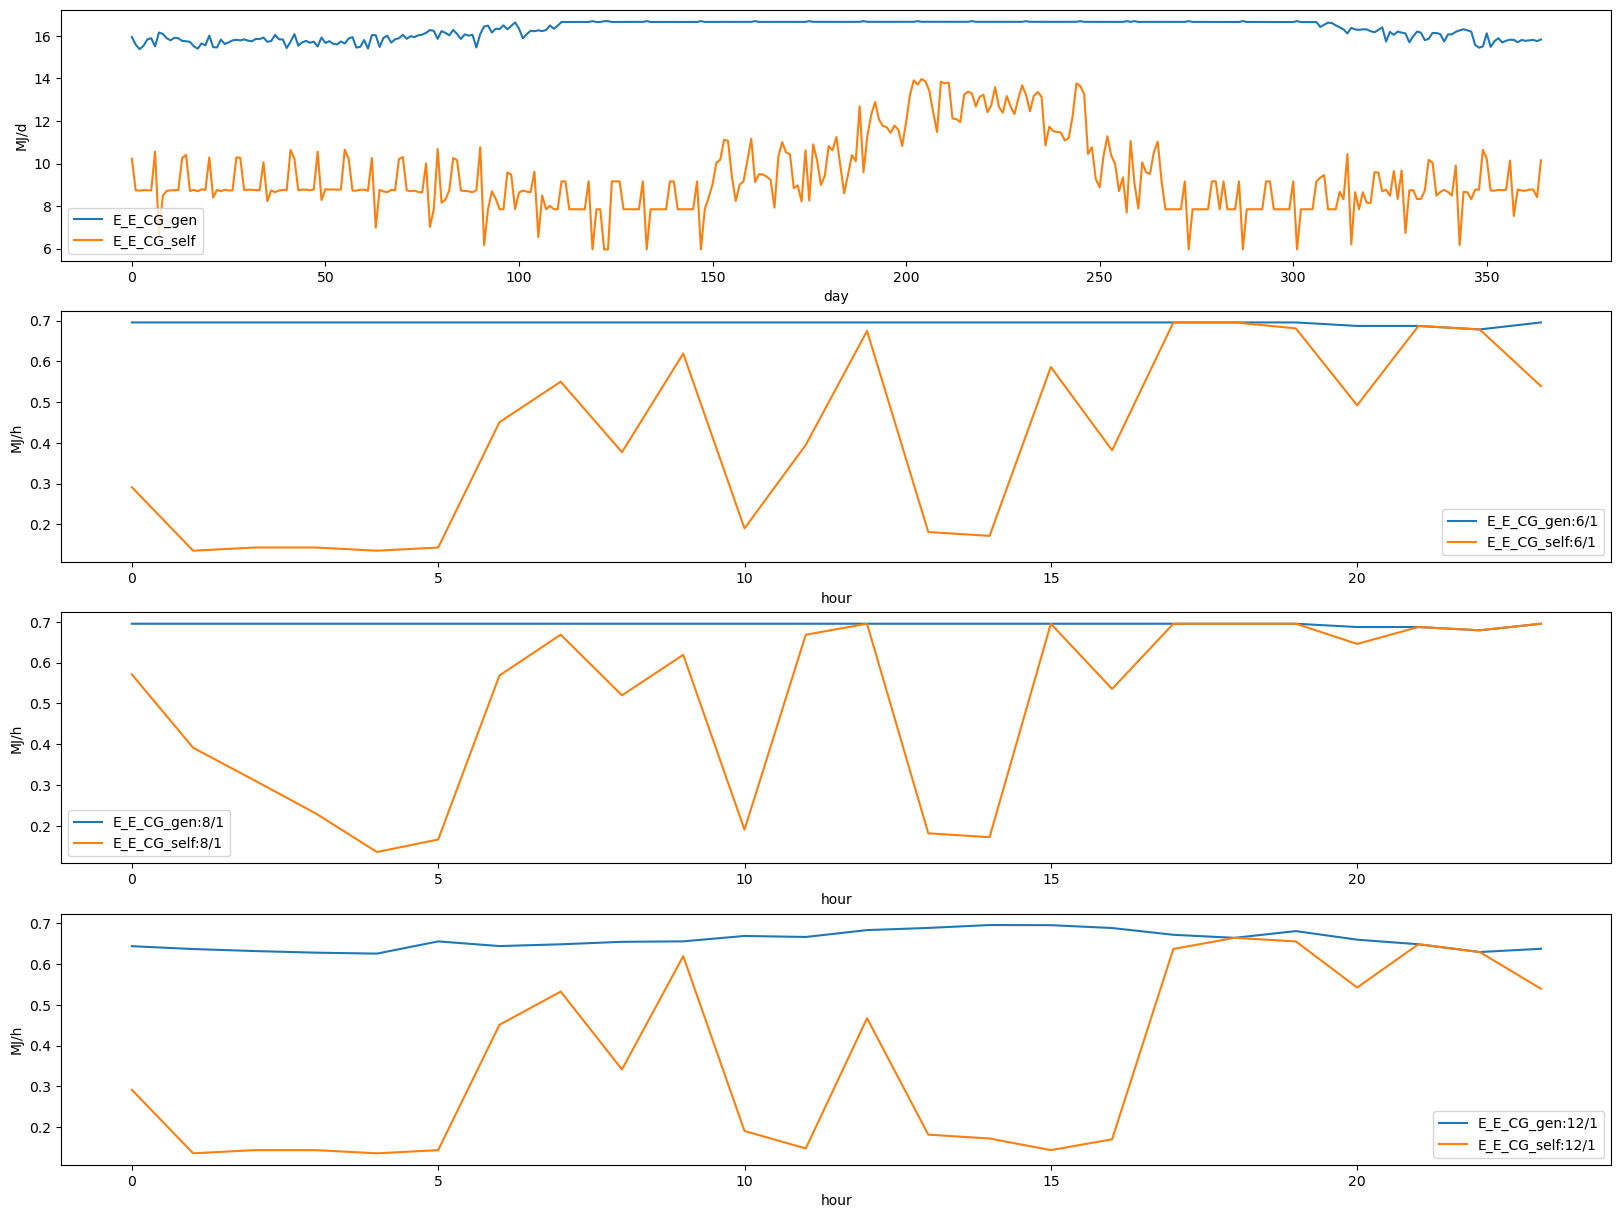

In [10]:
get_each_graph(E_E_CG_gen_d_t_3, E_E_CG_h_d_t_3)

## 比較

In [11]:
def draw_graph_oneside(df, myColumns, myColors, xlabel_unit):
    import matplotlib.pyplot as plt

    # 1行1列のグラフを作成
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5),sharey='row',dpi=150)

    # 区分名
    axNameArr = list(df.index)

    acc = np.zeros(len(df))
    for column,color in zip(myColumns,myColors):
        print(column, color)
        s = df[column]
        ax.barh(axNameArr,s,left=acc,color=color,label=column)
        acc+=s

    ax.set_xlabel(xlabel_unit)
    ax.legend()

    plt.show()

In [12]:
def draw_graph_bothside(df, x_columns,colors,x_range, x_label_units):

  import matplotlib.pyplot as plt
  import matplotlib.patheffects as pe 

  left_columns ,right_columns = x_columns
  left_colors,right_colors = colors

  # 1行2列のグラフを作成
  fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5),sharey='row',dpi=150)

  # 区分名
  axNameArr = list(df.index)

  # 左側のグラフ
  acc = np.zeros(len(df))
  for colum,color in reversed(list(zip(left_columns ,left_colors))):
    s = df[colum]
    ax[0].barh(axNameArr,s,left=acc,color=color,label=colum)
    acc+=s

  # 右側のグラフ
  acc = np.zeros(len(df))
  for colum,color in zip(right_columns,right_colors):
    s = df[colum]
    ax[1].barh(axNameArr,s,left=acc,color=color,label=colum)
    acc+=s

  # 凡例
  hans0, labs0 = ax[0].get_legend_handles_labels()
  hans1, labs1 = ax[1].get_legend_handles_labels()
  ax[1].legend(hans0+hans1, labs0+labs1)

  ax[0].set_xlabel(x_label_units[0])
  ax[1].set_xlabel(x_label_units[1])
  fig.align_labels() # ラベルの位置を揃える

  ax[0].set_xlim(x_range[0],0) # 左側グラフはX軸を反転
  ax[1].set_xlim(0,x_range[1])

  fig.subplots_adjust(wspace=0.0) # 左右のグラフの間隔をゼロに設定 
  
  plt.show()


In [13]:
import pandas as pd
DBdict = {'E_H_MJ': [E_H_1, E_H_2, E_H_3], 'E_W_MJ': [E_W_1, E_W_2, E_W_3], 
          'E_E_CG_gen_kWh': [np.sum(E_E_CG_gen_d_t_1), np.sum(E_E_CG_gen_d_t_2), np.sum(E_E_CG_gen_d_t_3)], 
          'E_E_CG_self_kWh': [np.sum(E_E_CG_h_d_t_1), np.sum(E_E_CG_h_d_t_2), np.sum(E_E_CG_h_d_t_3)],
          'E_E_CG_sell_kWh': [np.sum(E_E_CG_sell_d_t_1), np.sum(E_E_CG_sell_d_t_2), np.sum(E_E_CG_sell_d_t_3)],
          'E_G_CG_sell_MJ': [E_G_CG_sell_1, E_G_CG_sell_2, E_G_CG_sell_3]}
DB_ene = pd.DataFrame(DBdict, index=["testcase1", "testcase2", "testcase3"])
DB_ene


,E_H_MJ,E_W_MJ,E_E_CG_gen_kWh,E_E_CG_self_kWh,E_E_CG_sell_kWh,E_G_CG_sell_MJ
testcase1,3042.364959,66610.025989,3166.122896,3166.122896,0.000000,0.00000
testcase2,3042.364959,56202.439341,2522.684158,2522.684158,0.000000,0.00000
testcase3,3042.364959,79944.090284,5962.538230,3428.718652,2533.819578,18754.75459


### 給湯と暖房の一次エネルギー消費量の比較

E_H_MJ lightcoral
E_W_MJ royalblue


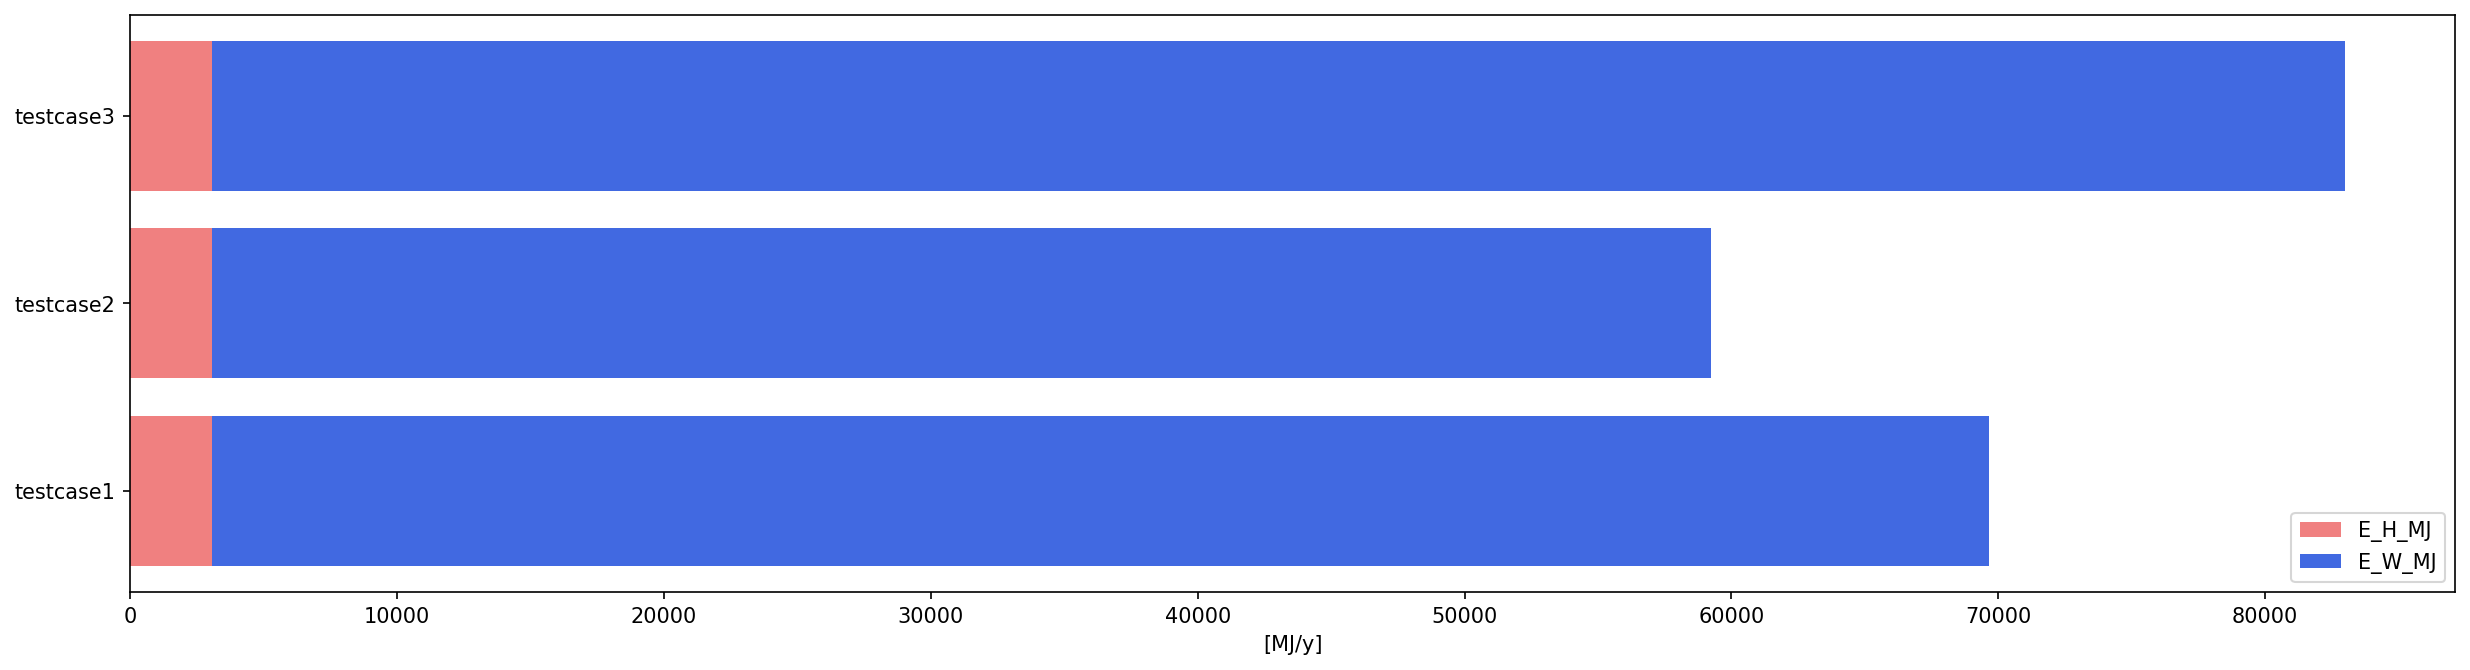

In [14]:
myColumns = ["E_H_MJ", "E_W_MJ"]
myColors = ['lightcoral', 'royalblue']

draw_graph_oneside(DB_ene, myColumns, myColors, "[MJ/y]")


### CGSの発電量と自家消費量の比較

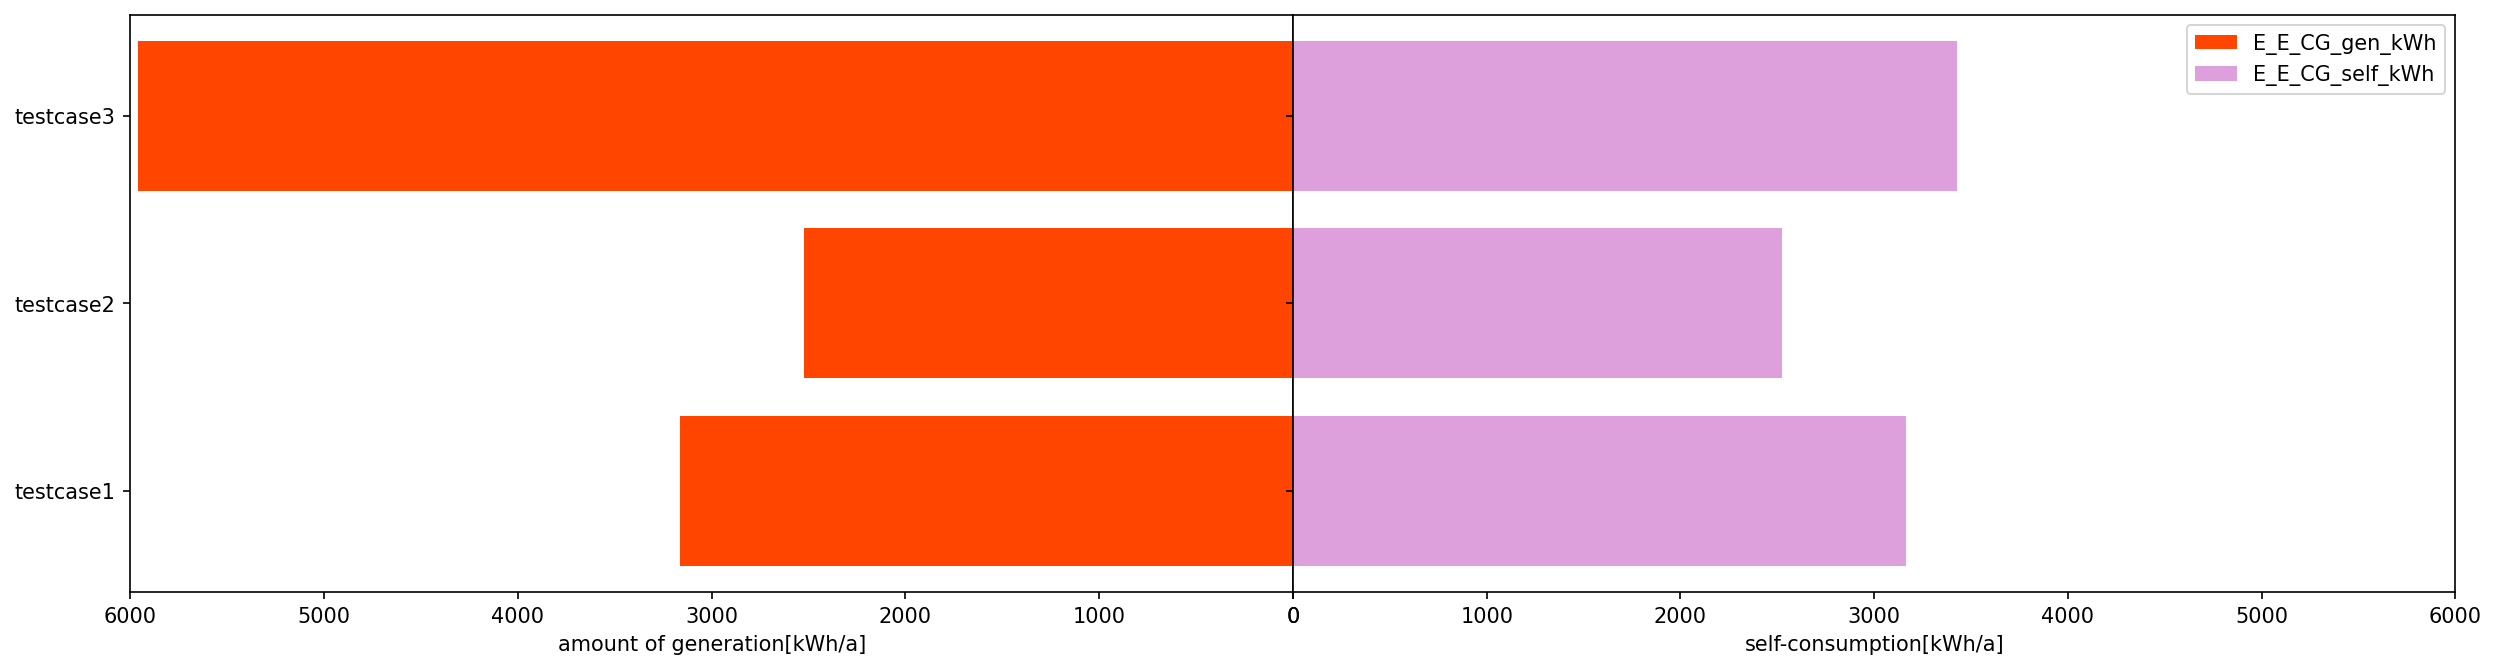

In [15]:
myColumns = [["E_E_CG_gen_kWh"], ["E_E_CG_self_kWh"]]
myColors = [['orangered'], ['plum']]
x_range = [6000,6000]
x_label_units = ['amount of generation[kWh/a]', 'self-consumption[kWh/a]']
draw_graph_bothside(DB_ene, myColumns, myColors, x_range, x_label_units)


### CGSの売電量に係るガス消費量の控除量と売電量の比較

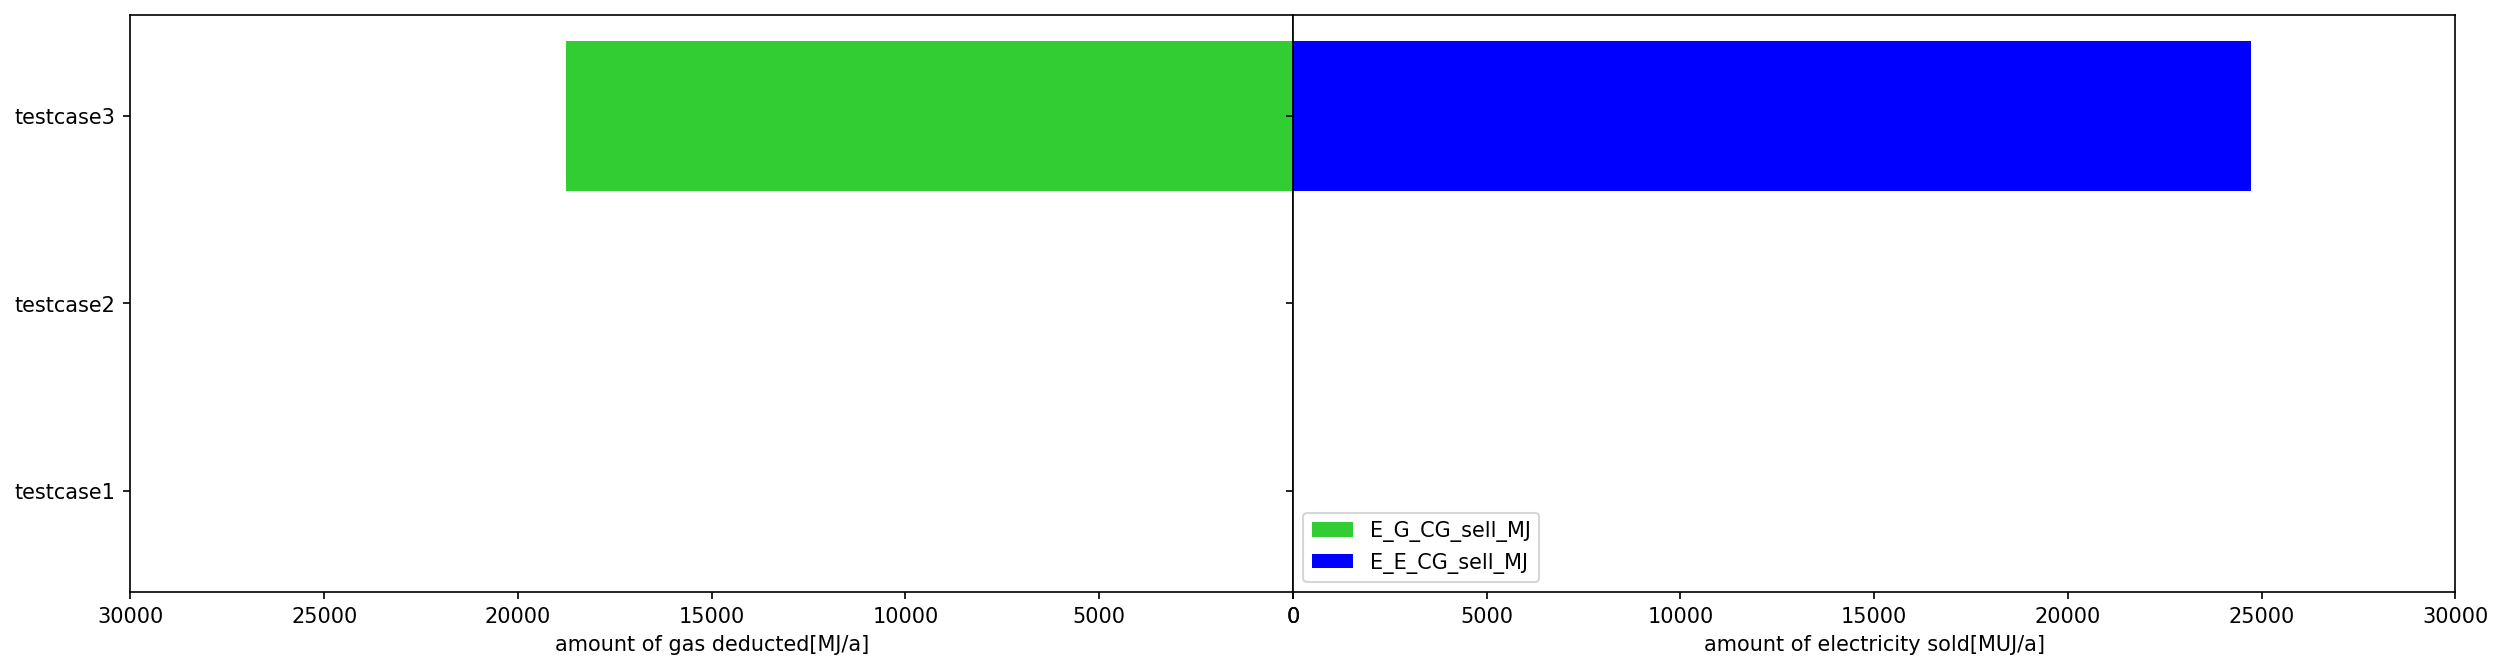

In [16]:
from pyhees.section2_1_b import get_f_prim
DB_ene['E_E_CG_sell_MJ'] = DB_ene['E_E_CG_sell_kWh'] * get_f_prim() /1000
myColumns = [["E_G_CG_sell_MJ"], ["E_E_CG_sell_MJ"]]
myColors = [['limegreen'], ['blue']]
x_range = [30000,30000]
x_label_units = ['amount of gas deducted[MJ/a]', 'amount of electricity sold[MUJ/a]']
draw_graph_bothside(DB_ene, myColumns, myColors, x_range, x_label_units)
